# Time Series Model for Yearly Copper Prices Using Python and ARIMA
### David Lowe
### July 22, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Yearly Copper Prices dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast the annual price of copper using the value of dollars in 1997 as the basis. The dataset describes a time-series of copper prices per ton (in dollars) over 198 years (1800-1996), and there are 197 observations. We used the first 80% of the observations for training various models while holding back the remaining observations for validating the final model.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 22.057. After performing a grid search for the most optimal ARIMA parameters, the final ARIMA non-seasonal order was (4, 1, 4). Furthermore, the chosen model processed the validation data with an RMSE of 21.456, which was better than the baseline model as expected.

CONCLUSION: For this dataset, the chosen ARIMA model achieved a satisfactory result, and we should consider using the algorithm for further modeling.

Dataset Used: Yearly Copper Prices 1800 through 1996

Dataset ML Model: Time series forecast with numerical attribute

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

A time series predictive modeling project generally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize Model and Make Predictions

## Task 1: Define Problem and Acquire Data

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load Libraries

In [5]:
# Create the random seed number for reproducible results
seedNum = 888

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import os
import sys
import math
import boto3
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# import pandas_datareader.data as web

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("ARIMA Task 1: Define Problem and Acquire Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [10]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('https://dainesanalytics.com/datasets/time-series-data-library/tsdl444.csv', index_col='idx', parse_dates=True)

# Load the dataset from the Federal Reserve Bank's FRED Database
# starting = datetime(1990, 1, 1)
# ending = datetime.now()
# fred_data = 'SMU06000007072251101'
# time_series = web.DataReader(fred_data, 'fred', starting, ending)
# time_series.rename(columns={fred_data: 'value'}, inplace=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [11]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [12]:
time_series.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 197 entries, 1800-01-01 to 1996-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   values  197 non-null    float64
dtypes: float64(1)
memory usage: 3.1 KB


In [13]:
time_series.head(10)

,values
idx,
1800-01-01,409.06
1801-01-01,389.08
1802-01-01,390.88
1803-01-01,436.33
1804-01-01,459.05
1805-01-01,452.57
1806-01-01,472.28
1807-01-01,388.60
1808-01-01,390.78


In [14]:
time_series.tail(10)

,values
idx,
1987-01-01,159.97
1988-01-01,165.84
1989-01-01,147.89
1990-01-01,125.99
1991-01-01,120.14
1992-01-01,99.90
1993-01-01,114.30
1994-01-01,99.86
1995-01-01,112.00


In [15]:
if notifyStatus: status_notify("ARIMA Task 1: Define Problem and Acquire Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2: Inspect and Explore Data

In [16]:
if notifyStatus: status_notify("ARIMA Task 2: Inspect and Explore Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [17]:
# Summary statistics of time series
print(time_series.describe())

           values
count  197.000000
mean   248.295635
std    104.272025
min     66.710000
25%    159.090000
50%    238.420000
75%    324.900000
max    474.580000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

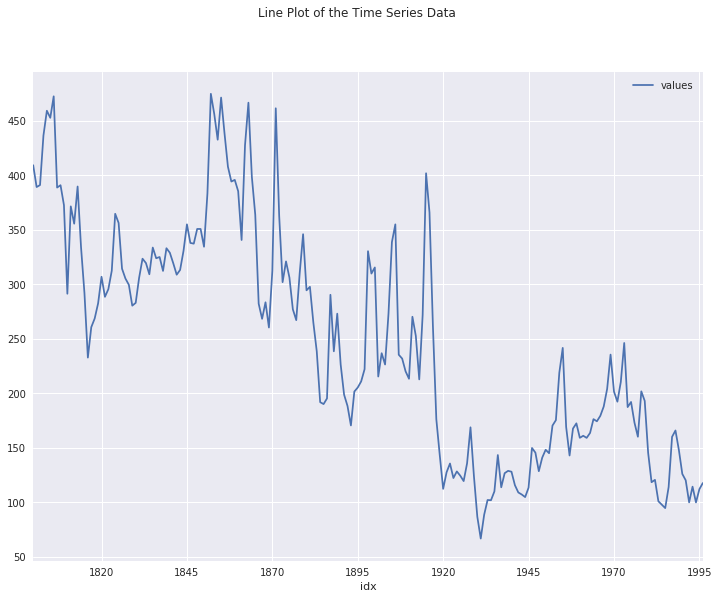

In [18]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

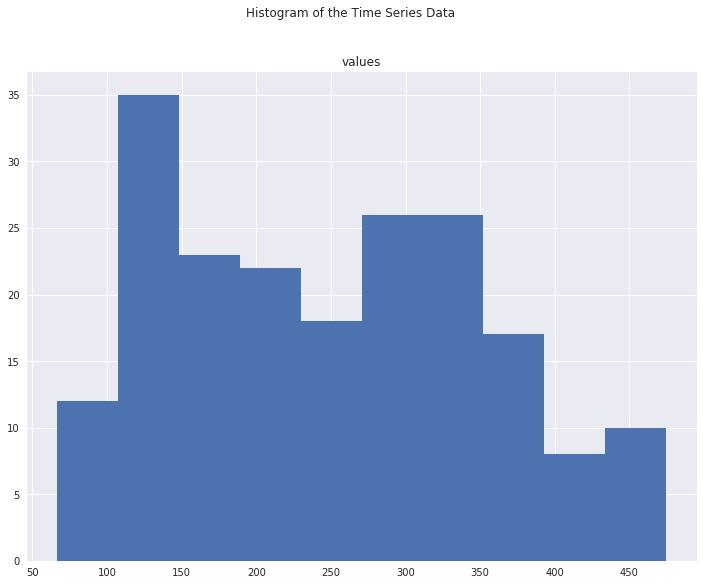

In [19]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

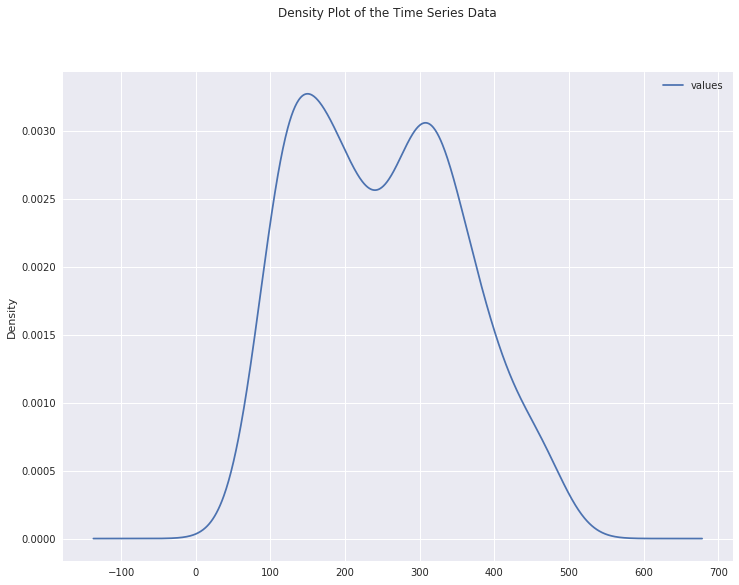

In [20]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

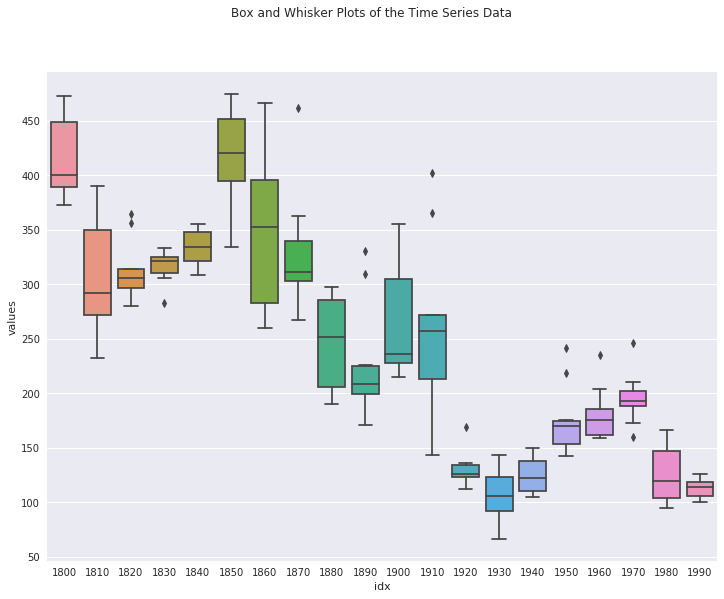

In [21]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Box and Whisker Plots of the Time Series Data')
squeezed = time_series.squeeze()
# sns.boxplot(squeezed.index.year, squeezed, ax=ax)
sns.boxplot(((squeezed.index.year//10)*10), squeezed, ax=ax)
plt.show()

In [22]:
if notifyStatus: status_notify("ARIMA Task 2: Inspect and Explore Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3: Clean and Pre-Process Data

In [23]:
if notifyStatus: status_notify("ARIMA Task 3: Clean and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### Section 3.a) Data Transformation

In [24]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

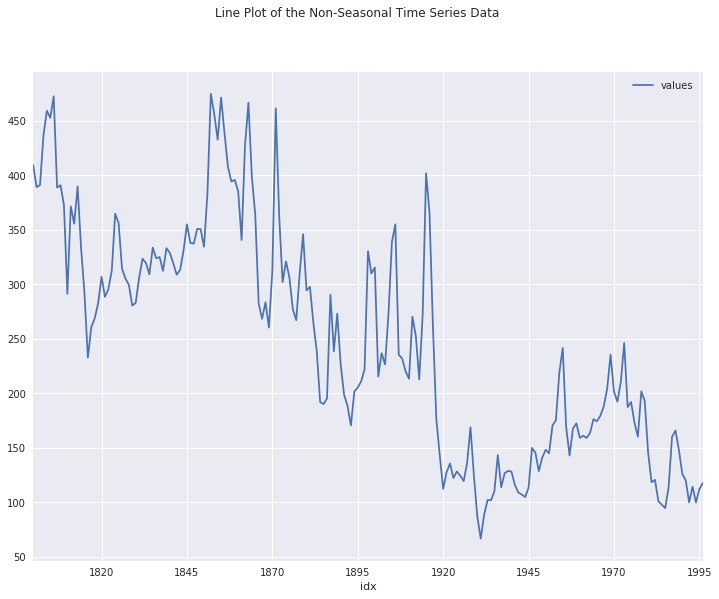

In [25]:
# Line plots of the transformed time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Non-Seasonal Time Series Data')
time_series.plot(ax=ax)
plt.show()

### Section 3.b) Test for Stationarity

In [26]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.105854
p-value: 0.712732
Critical Test Statistics Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


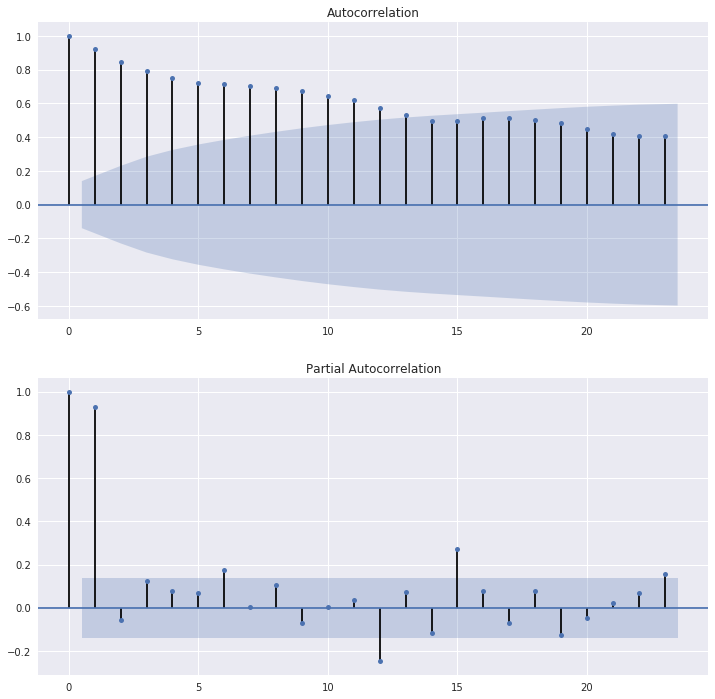

In [27]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 3.c) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

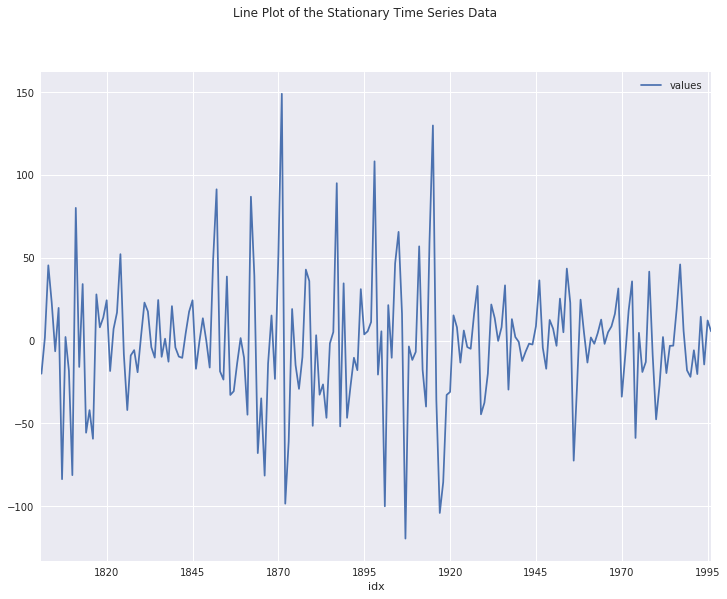

In [28]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [29]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.451524
p-value: 0.000240
Critical Test Statistics Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


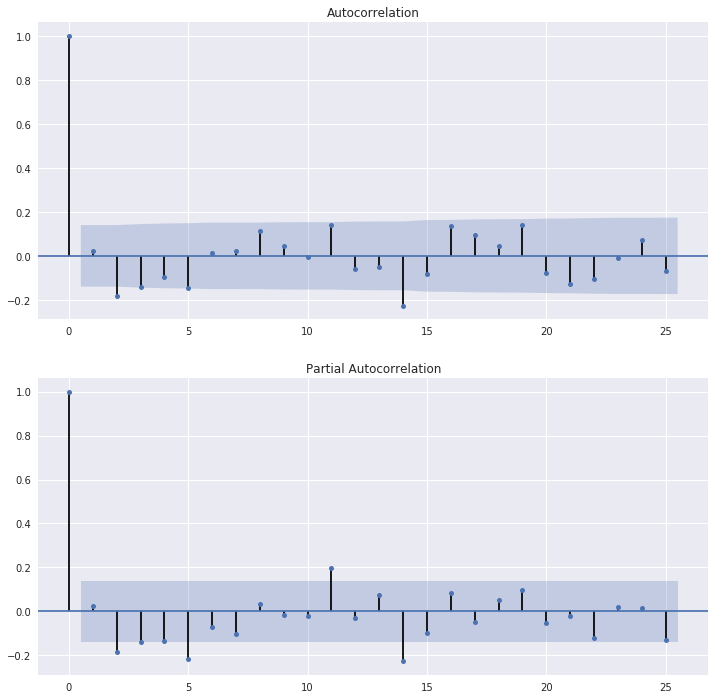

In [30]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

### 3.d) Seasonal Decomposition for Seasonal Time Series Data

In [31]:
# Set the initial seasonal frequency parameter
seasonal_freq = 0

In [32]:
# # Perform seasonal decomposition to observe the seasonal frequency
# decomp_results = seasonal_decompose(time_series, period=seasonal_freq)
# decomp_results.plot()
# plt.show()

In [33]:
# # Create a seasonal series
# N = seasonal_freq
# seasonal_series = time_series - time_series.rolling(N).mean()
# seasonal_series = seasonal_series.dropna()

# # Line plots of the seasonal time series
# fig, ax = plt.subplots(figsize=(12,9))
# fig.suptitle('Line Plot of the Seasonal Time Series Data')
# seasonal_series.plot(ax=ax)
# plt.show()

In [34]:
# # Check for stationarity
# result = adfuller(seasonal_series[target_col])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Test Statistics Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [35]:
# # ACF and PACF plots of the time series data
# lag = seasonal_freq * 2
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
# plot_acf(seasonal_series, lags=lag, ax=ax1)
# plot_pacf(seasonal_series, lags=lag, ax=ax2)
# plt.show()

### 3.e) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [36]:
# # Create a differenced series
# stationary_ss = time_series.diff(seasonal_freq).dropna()

# # Plot differenced data
# fig, ax = plt.subplots(figsize=(12,9))
# fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
# stationary_ss.plot(ax=ax)
# plt.show()

In [37]:
# # Check for stationarity
# result = adfuller(stationary_ss[target_col])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Test Statistics Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [38]:
# # ACF and PACF plots of the stationary time series
# lags = seasonal_freq * 2
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
# plot_acf(stationary_ss, lags=lags, ax=ax1)
# plot_pacf(stationary_ss, lags=lags, ax=ax2)
# plt.show()

In [39]:
if notifyStatus: status_notify("ARIMA Task 3: Clean and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4: Fit and Evaluate Models

In [40]:
if notifyStatus: status_notify("ARIMA Task 4: Fit and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

#### 4.a.iii) Establish the Persistent Model as Baseline

In [41]:
# Prepare and evaluate a persistence model
X = time_series.values
X = X.astype('float32')
train_pct = 0.80
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=169.090, Expected=143
>Predicted=142.870, Expected=168
>Predicted=167.590, Expected=172
>Predicted=172.370, Expected=159
>Predicted=159.090, Expected=161
>Predicted=160.970, Expected=159
>Predicted=159.040, Expected=164
>Predicted=163.570, Expected=176
>Predicted=176.230, Expected=174
>Predicted=174.240, Expected=179
>Predicted=179.240, Expected=188
>Predicted=187.810, Expected=204
>Predicted=203.940, Expected=235
>Predicted=235.420, Expected=202
>Predicted=201.510, Expected=192
>Predicted=192.240, Expected=210
>Predicted=210.320, Expected=246
>Predicted=246.090, Expected=187
>Predicted=187.290, Expected=192
>Predicted=191.980, Expected=173
>Predicted=173.010, Expected=160
>Predicted=160.080, Expected=202
>Predicted=201.700, Expected=193
>Predicted=192.950, Expected=145
>Predicted=145.380, Expected=118
>Predicted=118.400, Expected=121
>Predicted=120.550, Expected=101
>Predicted=100.910, Expected= 98
>Predicted=97.730, Expected= 95
>Predicted=94.660, Expected=114
>Predicted=1

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

In [42]:
if notifyStatus: status_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [43]:
# Set the initial P, D, and Q order parameters for non-seasonal ARIMA modeling
start_p = 0
start_q = 0
max_p = 4
max_d = 2
max_q = 4

In [44]:
# Set the initial P, D, and Q order parameters for seasonal ARIMA modeling
start_P = 0
start_D = None
start_Q = 0
max_P = 2
max_D = 1
max_Q = 2

In [45]:
# Testing the time series data for suggestions on the differencing term
start_d = pm.arima.ndiffs(train_ts)
print('The suggested non-seasonal differencing term is:', start_d)
if seasonal_freq != 0:
    start_D = pm.arima.nsdiffs(train_ts, m = seasonal_freq)
    print('The suggested seasonal differencing term is:', start_D)

The suggested non-seasonal differencing term is: 1


In [46]:
print('The initial non-seasonal parameters are: p =', start_p, '| d =', start_d, '| q =', start_q)
print('The maximum non-seasonal parameters are: max_p =', max_p, '| max_d =', max_d, '| max_q =', max_q)
if seasonal_freq != 0:
    print('The initial seasonal parameters are: P =', start_P, '| D =', start_D, '| Q =', start_Q, '| m =', seasonal_freq)
    print('The maximum seasonal parameters are: max_P =', max_P, '| max_D =', max_D, '| max_Q =', max_Q)

The initial non-seasonal parameters are: p = 0 | d = 1 | q = 0
The maximum non-seasonal parameters are: max_p = 4 | max_d = 2 | max_q = 4


In [47]:
# Do an automated stepwise search of ARIMA parameters
if seasonal_freq == 0:
    stepwise_results = pm.auto_arima(train_ts, seasonal = False, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    stepwise_results = pm.auto_arima(train_ts, seasonal = True, m = seasonal_freq, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=1593.537, BIC=1611.836, Time=0.868 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1604.998, BIC=1611.098, Time=0.029 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1606.939, BIC=1616.089, Time=0.113 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1606.909, BIC=1616.058, Time=0.241 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1603.218, BIC=1606.268, Time=0.023 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1595.490, BIC=1610.739, Time=0.872 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1595.026, BIC=1610.275, Time=0.384 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=1595.532, BIC=1616.881, Time=1.036 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=1598.941, BIC

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -790.768
Date:                Fri, 17 Jul 2020   AIC                           1593.537
Time:                        21:25:13   BIC                           1611.836
Sample:                             0   HQIC                          1600.969
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6054      0.714     -0.847      0.397      -2.005       0.795
ar.L1          1.3508      0.158      8.551      0.000       1.041       1.660
ar.L2         -0.7337      0.120     -6.127      0.0

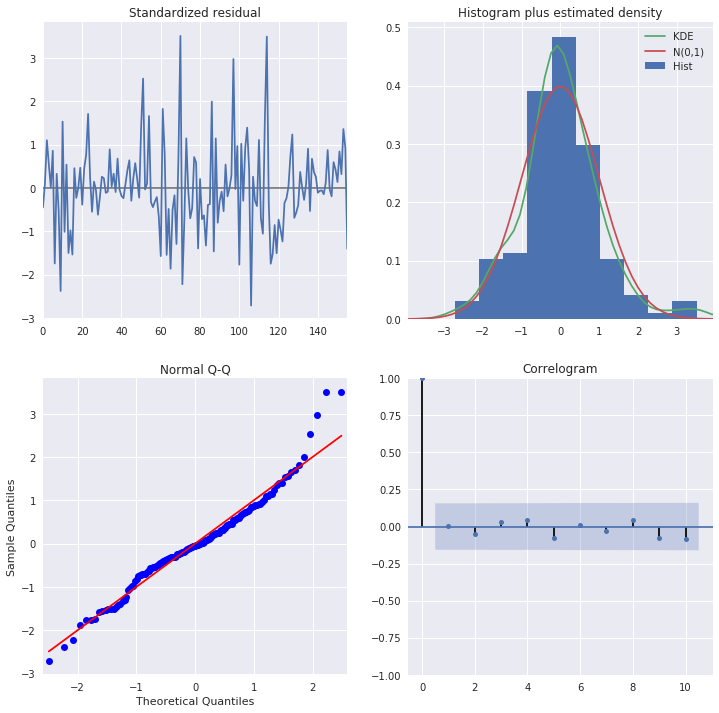

In [48]:
# Summarize residual errors for the automated grid search ARIMA model
print(stepwise_results.summary())
stepwise_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [49]:
if notifyStatus: status_notify("ARIMA automated stepwise search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
# Do an automated random search of ARIMA parameters
n_fits = int(max_p * max_d * max_q * max_P * max_D * max_Q * 0.30)
if seasonal_freq == 0:
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)
else:
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1606.939, BIC=1616.089, Time=0.119 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1604.256, BIC=1616.455, Time=0.236 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=1597.279, BIC=1618.628, Time=0.789 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1606.909, BIC=1616.058, Time=0.285 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=1597.689, BIC=1615.988, Time=0.478 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=1597.430, BIC=1615.729, Time=0.814 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=1601.964, BIC=1620.263, Time=0.486 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1601.533, BIC=1613.732, Time=0.391 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1595.026, BIC=1610.275, Time=0.388 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1596.269, BIC=1608.469, Time=0.672 seconds
Fit ARIMA(4,1,3)x(0,0,0,0) [intercept=True]; AIC=1599.488, BIC=1626.937, Time=1.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -785.284
Date:                Fri, 17 Jul 2020   AIC                           1590.568
Time:                        21:25:34   BIC                           1621.067
Sample:                             0   HQIC                          1602.956
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9298      2.272     -0.849      0.396      -6.384       2.524
ar.L1         -0.0706      0.200     -0.353      0.724      -0.462       0.321
ar.L2          0.3669      0.178      2.057      0.0

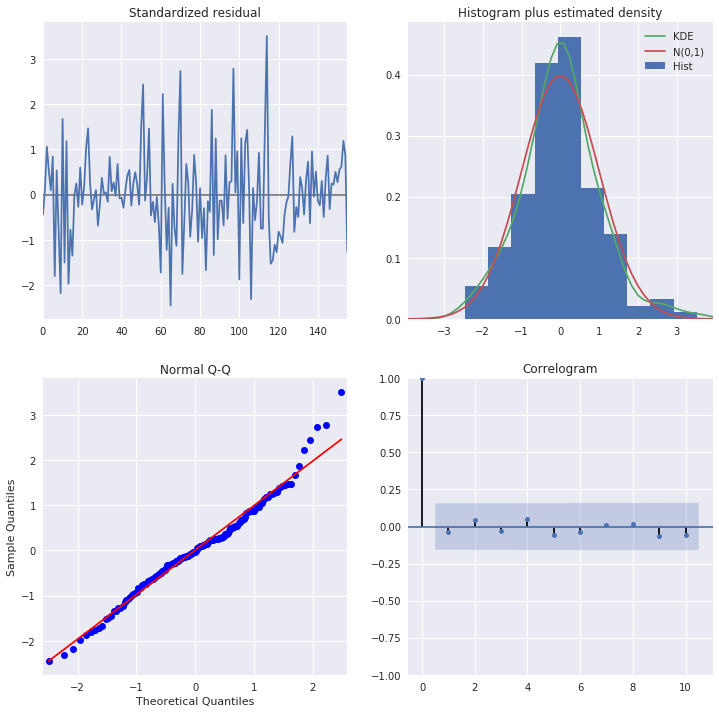

In [51]:
# Summarize residual errors for the automated grid search ARIMA model
print(randgrid_results.summary())
randgrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [52]:
if notifyStatus: status_notify("ARIMA automated random search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
# Do an automated grid search of ARIMA parameters
if (seasonal_freq == 0):
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1604.998, BIC=1611.098, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1606.909, BIC=1616.058, Time=0.285 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1601.533, BIC=1613.732, Time=0.312 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=1596.323, BIC=1611.572, Time=0.416 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=1597.689, BIC=1615.988, Time=0.465 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1606.939, BIC=1616.089, Time=0.116 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1596.269, BIC=1608.469, Time=0.652 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1595.490, BIC=1610.739, Time=0.876 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=1597.430, BIC=1615.729, Time=0.799 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=1599.396, BIC=1620.745, Time=0.812 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1604.256, BIC=1616.455, Time=0.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -785.284
Date:                Fri, 17 Jul 2020   AIC                           1590.568
Time:                        21:25:55   BIC                           1621.067
Sample:                             0   HQIC                          1602.956
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9298      2.272     -0.849      0.396      -6.384       2.524
ar.L1         -0.0706      0.200     -0.353      0.724      -0.462       0.321
ar.L2          0.3669      0.178      2.057      0.0

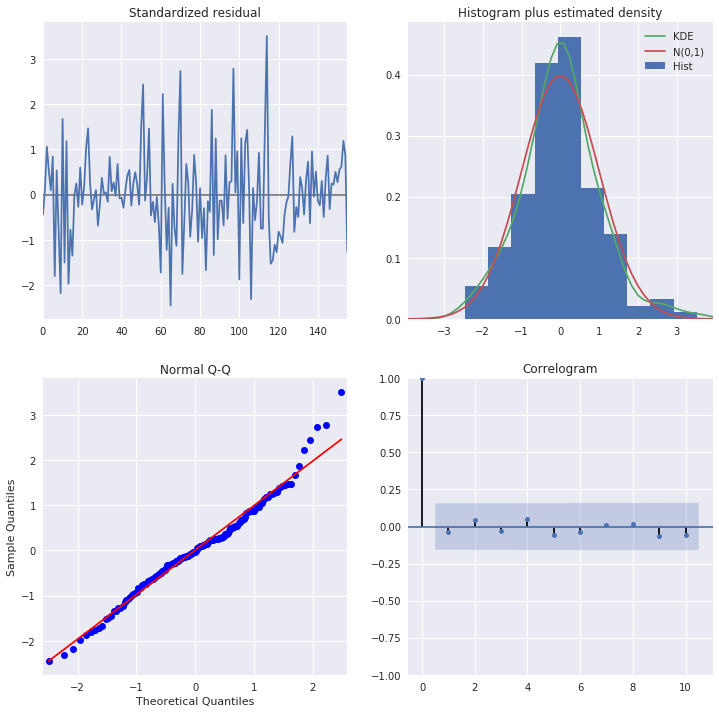

In [54]:
# Summarize residual errors for the automated grid search ARIMA model
print(autogrid_results.summary())
autogrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [55]:
if notifyStatus: status_notify("ARIMA automated grid search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
# Not applicable for this iteration of the project

# Set up the function to handle the ARIMA calculation
# def Calculate_ARIMA(ns_order, ss_order):
#     startTimeModel = datetime.now()
#     aic_score, bic_score = float("inf"), float("inf")
#     if (verbose): print('Trying to fit the model with parameters:', ns_order, ss_order)
#     try:
#         if (ss_order[3] == 0): grid_model = SARIMAX(train_ts, order=ns_order)
#         else: grid_model = SARIMAX(train_ts, order=ns_order, seasonal_order=ss_order)
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             grid_results = grid_model.fit(disp = False)
#         aic_score = grid_results.aic
#         bic_score = grid_results.bic
#         if (verbose): print('Fit ARIMA: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f, Fit time=%s' % 
#               (ns_order, ss_order, aic_score, bic_score, (datetime.now() - startTimeModel)))
#         return(aic_score, bic_score)
#     except:
#         return(float("inf"), float("inf"))

In [57]:
# Not applicable for this iteration of the project

# Do a manual grid search of ARIMA parameters
# best_score, best_ns_cfg, best_ss_cfg = float("inf"), None, None
# for p in range(start_p, max_p+1):
#     for d in range(start_d, max_d+1):
#         for q in range(start_q, max_q+1):
#             for P in range(start_P, max_P+1):
#                 for D in range(start_D, max_D+1):
#                     for Q in range(start_Q, max_Q+1):
#                         ns_order = (p, d, q)
#                         ss_order = (P, D, Q, seasonal_freq)
#                         aic_score, bic_score = Calculate_ARIMA(ns_order, ss_order)
#                         if (aic_score < best_score):
#                             best_ns_cfg, best_ss_cfg, best_score = ns_order, ss_order, aic_score
#                             print('A better model found: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f' % (ns_order, ss_order, aic_score, bic_score))
# print('Best ARIMA model via manual search: order=%s seasonal_order=%s; AIC=%f' % (best_ns_cfg, best_ss_cfg, best_score))

In [58]:
# Summarize residual errors for the manual ARIMA model
# manual_model = SARIMAX(train_ts, order=best_ns_cfg, seasonal_order=best_ss_cfg)
# manual_results = manual_model.fit(disp = False)
# print(manual_results.summary())
# manual_results.plot_diagnostics(figsize=(12,12))
# plt.show()

In [59]:
if notifyStatus: status_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

In [60]:
# Set the ARIMA order parameters for validation and forecasting
# final_ns_order = stepwise_results.order
final_ns_order = randgrid_results.order
# final_ns_order = autogrid_results.order
# final_ns_order = best_ns_cfg
if seasonal_freq != 0:
    final_ss_order = stepwise_results.seasonal_order
#     final_ss_order = randgrid_results.seasonal_order
#     final_ss_order = autogrid_results.seasonal_order
#     final_ss_order = best_ss_cfg
    print("Final Non-season order:", final_ns_order, 'Final Seasonal Order:', final_ss_order)
else:
    print("Final Non-season order:", final_ns_order)

Final Non-season order: (4, 1, 4)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization faile

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  197
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -972.725
Date:                Fri, 17 Jul 2020   AIC                           1963.449
Time:                        21:25:59   BIC                           1992.952
Sample:                    01-01-1800   HQIC                          1975.393
                         - 01-01-1996                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0531      0.159     -0.334      0.738      -0.365       0.259
ar.L2          0.3124      0.137      2.274      0.023       0.043       0.582
ar.L3          0.1947      0.097      2.010      0.0

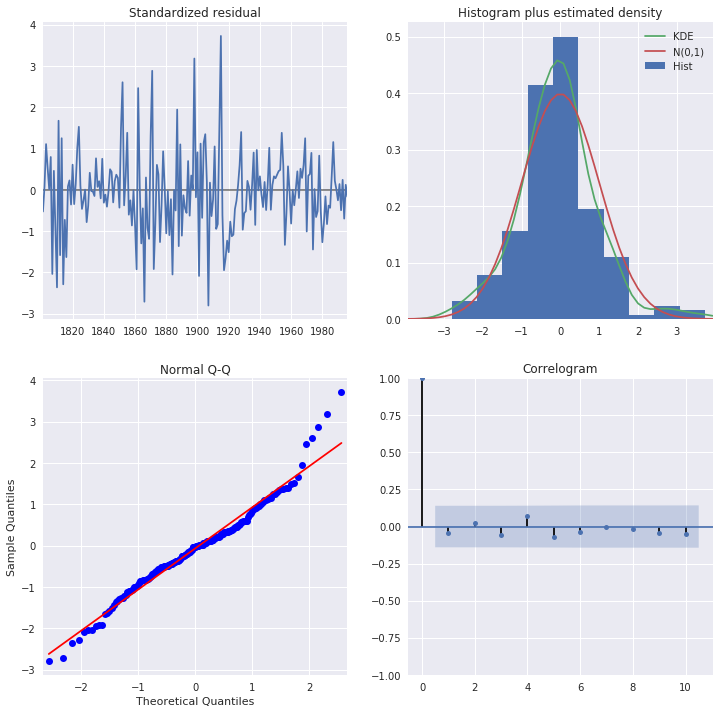

In [61]:
# Summarize residual errors for the final ARIMA model
if seasonal_freq != 0:
    final_model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
else:
    final_model = SARIMAX(time_series, order=final_ns_order)
final_results = final_model.fit(disp = False)
print(final_results.summary())
final_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [62]:
if notifyStatus: status_notify("ARIMA Task 4: Fit and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model and Make Predictions

In [63]:
if notifyStatus: status_notify("ARIMA Task 5: Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Validation via In-sample Data

In [64]:
validate_forecast = final_results.get_prediction(start = -test_size)
mean_validate_forecast = validate_forecast.predicted_mean
validate_confidence_intervals = validate_forecast.conf_int()

In [65]:
# Occasionally some predicted values turned out to be < 0 but they should not be (e.g. rainfall, disease cases, etc.)
# If we have those values, we will need to set them to 0
# print(mean_validate_forecast[mean_validate_forecast < 0])
# mean_validate_forecast[mean_validate_forecast < 0] = 0

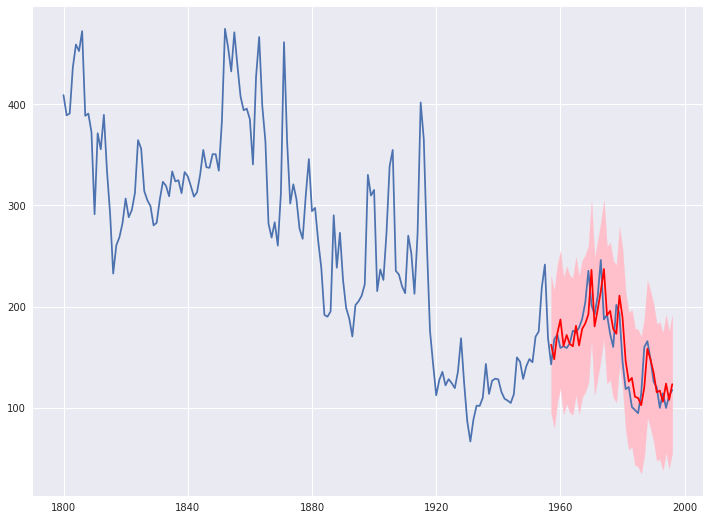

In [66]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_validate_forecast.index, mean_validate_forecast.values, color='red', label='forecast')
plt.fill_between(validate_confidence_intervals.index, validate_confidence_intervals[lower_bound], 
                 validate_confidence_intervals[upper_bound], color='pink')
plt.show()

In [67]:
# Evaluate RMSE for the validation data
y_test = time_series[-test_size:]
predictions = mean_validate_forecast.values
for i in range(y_test.shape[0]):
    print(y_test.index[i], ' | ', y_test.iloc[i,0], ' | ', predictions[i])
print('RMSE from the validation data is: %.3f' % math.sqrt(mean_squared_error(y_test, predictions)))

1957-01-01 00:00:00  |  142.87  |  162.37364438206583
1958-01-01 00:00:00  |  167.59  |  147.99002907112475
1959-01-01 00:00:00  |  172.37  |  173.37742293498658
1960-01-01 00:00:00  |  159.09  |  187.24570082408434
1961-01-01 00:00:00  |  160.97  |  161.15900967346636
1962-01-01 00:00:00  |  159.04  |  171.93431884292937
1963-01-01 00:00:00  |  163.57  |  163.06670823044283
1964-01-01 00:00:00  |  176.23  |  160.80823789591867
1965-01-01 00:00:00  |  174.24  |  181.0983984592088
1966-01-01 00:00:00  |  179.24  |  161.63209626506048
1967-01-01 00:00:00  |  187.81  |  177.88389245879975
1968-01-01 00:00:00  |  203.94  |  183.30255168914655
1969-01-01 00:00:00  |  235.42  |  192.385939630508
1970-01-01 00:00:00  |  201.51  |  236.2914357063006
1971-01-01 00:00:00  |  192.24  |  180.46328973466774
1972-01-01 00:00:00  |  210.32  |  197.181866594991
1973-01-01 00:00:00  |  246.09  |  215.26801279618414
1974-01-01 00:00:00  |  187.29  |  237.11036092462382
1975-01-01 00:00:00  |  191.98  | 

### 5.b) Forecasting Out-of-Sample Data

In [68]:
if seasonal_freq != 0:
    forecast_size = seasonal_freq
else:
    forecast_size = 1
final_forecast = final_results.get_forecast(steps = forecast_size)
mean_final_forecast = final_forecast.predicted_mean
final_confidence_intervals = final_forecast.conf_int()
print("The forecasted values are:\n\n", mean_final_forecast)

The forecasted values are:

 1997-01-01    120.499108
Freq: AS-JAN, dtype: float64


In [69]:
# Occasionally some predicted values turned out to be < 0 but they should not be (e.g. rainfall, disease cases, etc.)
# If we have those values, we will need to set them to 0
# print(mean_final_forecast[mean_final_forecast < 0])
# mean_final_forecast[mean_final_forecast < 0] = 0

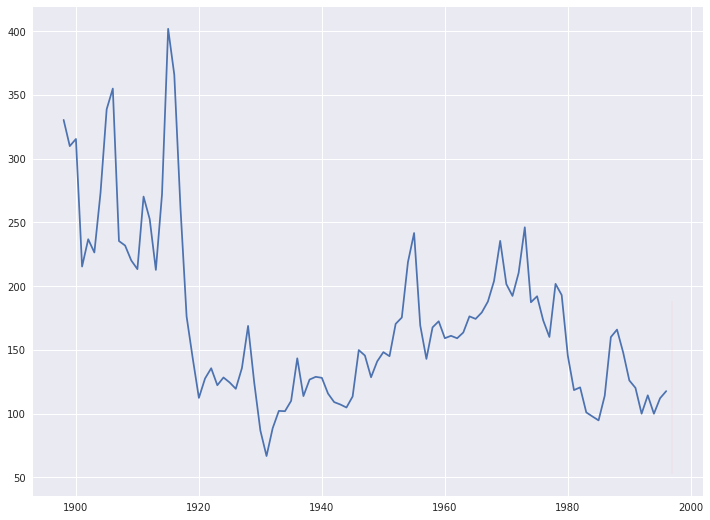

In [70]:
plt.figure(figsize=(12,9))
halfway_point = int(time_series.index.size / 2)
plt.plot(time_series.index[halfway_point:], time_series[target_col][halfway_point:], label='observed')
plt.plot(mean_final_forecast.index, mean_final_forecast.values, color='red', label='forecast')
plt.fill_between(final_confidence_intervals.index, final_confidence_intervals[lower_bound], 
                 final_confidence_intervals[upper_bound], color='pink')
plt.show()

In [71]:
if notifyStatus: status_notify("ARIMA Task 5: Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [72]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:10.015680
